In [1]:
!pip install meshio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.7/167.7 kB 3.6 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.7/239.7 kB 5.0 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.5/87.5 kB 2.7 MB/s eta 0:00:00
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.

[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python -m pip install --upgrade pip


In [2]:
import torch
import math
from simple_fem import FEM, import_mesh, Quad
import matplotlib.pyplot as plt
from math import sqrt
import meshio as meshio
import numpy as np

torch.set_default_dtype(torch.double)


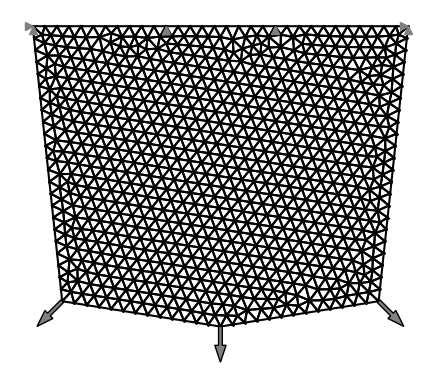

In [19]:
# Import mesh with element size factor 0.26 created using gmsh
hood = import_mesh("hood-026.vtk", 50000.0, 0.33)
# Units = 50000 = 150 GPa, i.e. 1000 = 1 GPa, 1.0 = 1 MPa

hood.constraints[37:38, 1] = True # Away from the corners
hood.constraints[46:47, 1] = True # Away from the corners

# Front corners
hood.forces[0, 1] = -2000.0 # Right corner
hood.forces[0, 0] = 2000.0 # Right corner
hood.forces[3, :] = -2000.0 # Left corner
hood.forces[4, 1] = -2000.0 # Frontmost corner

# Forces converge upto 2000 MPa, beyond which the structure changes or fails to converge.

# Back corners
hood.constraints[1, :] = True
hood.constraints[2, :] = True

# Material properties
nu = 0.33
E = 150000.0

# Thickness
d = 0.1
thickness = d * torch.ones(len(hood.elements))

# Plot the fillet
Tria = FEM(hood.nodes, hood.elements, hood.forces, hood.constraints, thickness=thickness, E=E, nu=nu)
Tria.plot()

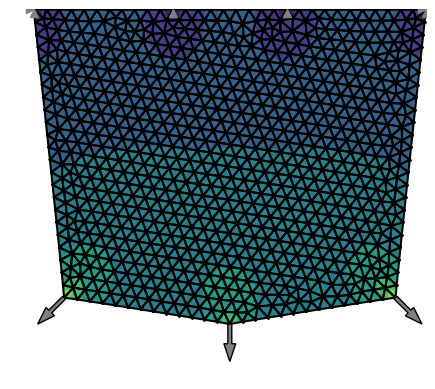

In [20]:
# Solve
u, f = Tria.solve()

# Plot
Tria.plot(u, node_property=torch.norm(u, dim=1))

In [14]:
def bisection(f, a, b, max_iter=50, tol=1e-12):
    # Bisection method always finds a root, even with highly non-linear grad
    i = 0
    while (b - a) > tol:
        c = (a + b) / 2.0
        if i > max_iter:
            raise Exception(f"Bisection did not converge in {max_iter} iterations.")
        if f(a) * f(c) > 0:
            a = c
        else:
            b = c
        i += 1
    return c

In [15]:
def optimize(fem, rho_0, rho_min, rho_max, V_0, iter=1, xi=0.5, m=0.2, p=1.0, r=0.0):
    rho = [rho_0]
    vols = d * fem.areas()

    # Check if there is a feasible solution before starting iteration
    if torch.inner(rho_min, vols) > V_0:
        raise Exception("rho_min is not compatible with V_0.")

    # Precompute filter weights
    if r > 0.0:
        H = r - fem.dist
        H[fem.dist > r] = 0.0

    # Iterate solutions
    for k in range(iter):
        # Adjust thickness variables
        fem.thickness = d * rho[k] ** p

        # Compute solution
        u_k, f_k = fem.solve()

        # Compute sensitivities
        w_k = fem.element_strain_energies(u_k)
        sensitivity = -p * d * rho[k] ** (p - 1) * 2.0 * w_k

        # Filter sensitivities (if r provided)
        if r > 0.0:
            sensitivity = H @ (rho[k] * sensitivity) / H.sum(dim=0) / rho[k]

        # For a certain value of mu, apply the iteration scheme
        def make_step(mu):
            G_k = -sensitivity / (mu * vols)
            upper = torch.min(rho_max, (1 + m) * rho[k])
            lower = torch.max(rho_min, (1 - m) * rho[k])
            rho_trial = G_k**xi * rho[k]
            return torch.maximum(torch.minimum(rho_trial, upper), lower)

        # Constraint function
        def g(mu):
            rho_k = make_step(mu)
            return torch.dot(rho_k, vols) - V_0

        # Find the root of g(mu)
        mu = bisection(g, 1e-10, 100.0)

        # Evaluation
        compliance = torch.inner(f_k.ravel(), u_k.ravel())
        print(f"Iteration k={k} - Compliance: {compliance:.5f}")

        rho.append(make_step(mu))

    return rho

In [16]:
# Initial thickness, minimum thickness, maximum thickness
rho_0 = 0.5 * torch.ones(len(hood.elements))
rho_min = 0.01 * torch.ones_like(rho_0)
rho_max = 1.0 * torch.ones_like(rho_0)

# Initial volume (40% of maximum design volume)
vols = d * hood.areas()
V0 = 0.4 * vols.sum()

Iteration k=0 - Compliance: 963007.17409
Iteration k=1 - Compliance: 322649.89361
Iteration k=2 - Compliance: 109104.60572
Iteration k=3 - Compliance: 89283.45892
Iteration k=4 - Compliance: 45955.83155
Iteration k=5 - Compliance: 63581.48939
Iteration k=6 - Compliance: 41718.15187
Iteration k=7 - Compliance: 54342.37733
Iteration k=8 - Compliance: 37136.42727
Iteration k=9 - Compliance: 54803.19838
Iteration k=10 - Compliance: 37600.81214
Iteration k=11 - Compliance: 53748.49044
Iteration k=12 - Compliance: 37565.95567
Iteration k=13 - Compliance: 52749.79735
Iteration k=14 - Compliance: 37470.32376
Iteration k=15 - Compliance: 49295.52524
Iteration k=16 - Compliance: 37035.45450
Iteration k=17 - Compliance: 46592.81508
Iteration k=18 - Compliance: 37915.63569
Iteration k=19 - Compliance: 39944.84444
Iteration k=20 - Compliance: 36941.79107
Iteration k=21 - Compliance: 35231.84179
Iteration k=22 - Compliance: 34024.32654
Iteration k=23 - Compliance: 33424.16157
Iteration k=24 - Compli

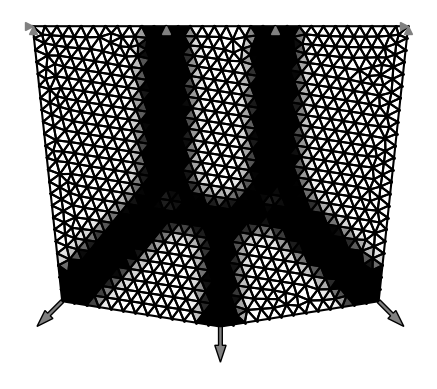

In [21]:
# Optimize and visualize results
d_opt = optimize(hood, rho_0, rho_min, rho_max, V0, iter=150, p=6, r=14)
# Use p = 6 and r 0 14 for convergence in 150 iterations.
hood.plot(element_property=d_opt[-1])

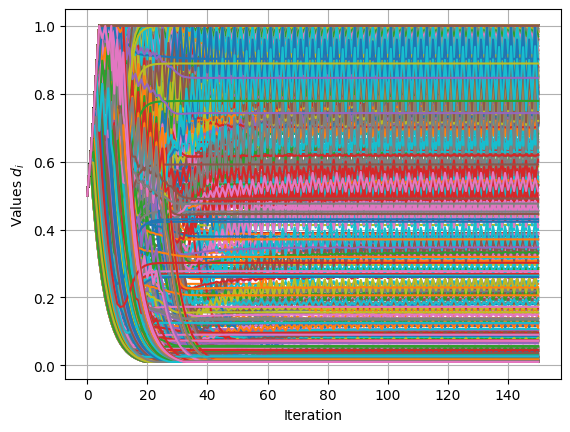

In [18]:
import matplotlib.pyplot as plt

plt.plot(torch.stack(d_opt).detach())
plt.xlabel("Iteration")
plt.ylabel("Values $d_i$")
plt.grid()

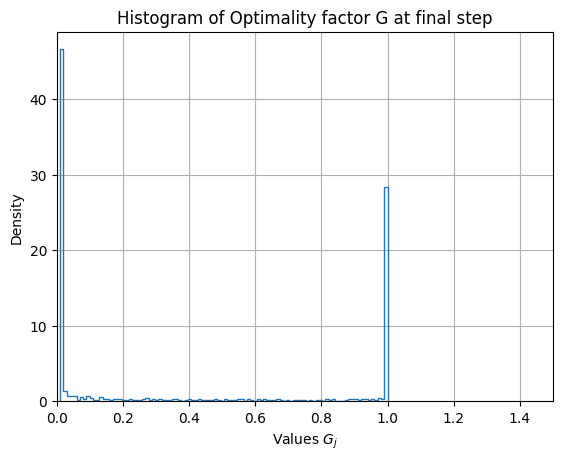

In [10]:
plt.figure()
plt.hist(d_opt[-1], density=True, bins=100, histtype='step')
plt.xlabel("Values $G_j$")
plt.ylabel("Density")
plt.title("Histogram of Optimality factor G at final step")
plt.xlim((0, 1.5))
plt.grid()